Intro : liens

avec les données building_1298 compteur 0

* [pymc](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/Gaussian_Processes.html)
* [Covariance functions](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
import pymc as pm

In [3]:
df = pd.read_csv("data/gpdata.csv", index_col=0, parse_dates=True)
df.head()

,air_temperature,dew_temperature,wind_speed,m0
datetime,,,,
2016-01-01 00:00:00,5.6,-0.6,2.6,416.169
2016-01-01 01:00:00,5.6,-0.6,2.6,408.616
2016-01-01 02:00:00,5.6,-0.6,2.6,412.072
2016-01-01 03:00:00,5.6,-1.1,1.5,393.053
2016-01-01 04:00:00,5.0,-2.2,3.1,404.519


Text(0.5, 0, 'm0')

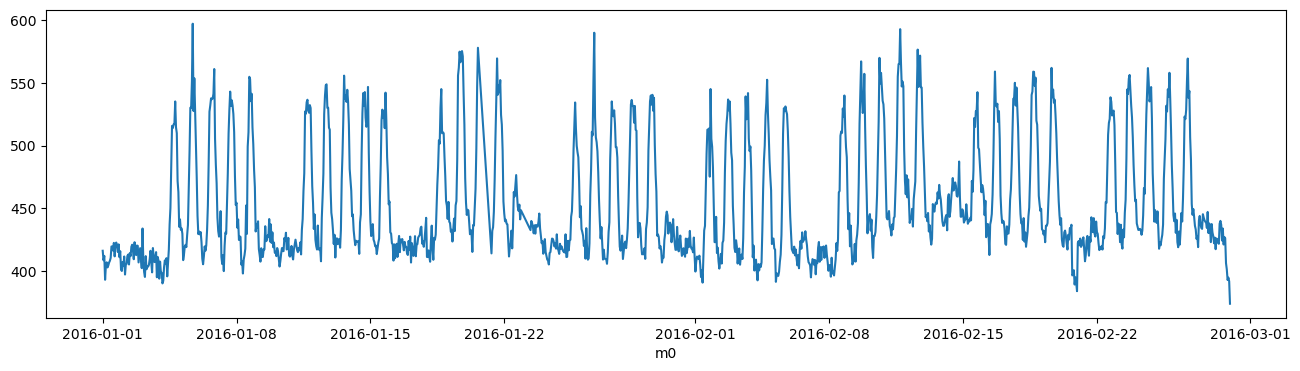

In [4]:
# A plot of the dependent variable vs. each of the explanatory variables
dfplot = df.loc['2016-01-01':'2016-02-28']
_, ax = plt.subplots(figsize=(16, 4))
#axes[0].plot(df['datetime'], df['Ti'], alpha=0.6)
#axes[0].plot(df['datetime'], df['Te'], alpha=0.6)
ax.plot(dfplot.index, dfplot['m0'])
ax.set_xlabel("time")
ax.set_xlabel("m0")

In [5]:
df_train = df.loc['2016-01-01':'2016-01-31']
df_train["weekday"] = df_train.index.weekday
df_train["hour"] = df_train.index.hour

df_train.head()

/tmp/ipykernel_4304/2362969344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["weekday"] = df_train.index.weekday
/tmp/ipykernel_4304/2362969344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["hour"] = df_train.index.hour


,air_temperature,dew_temperature,wind_speed,m0,weekday,hour
datetime,,,,,,
2016-01-01 00:00:00,5.6,-0.6,2.6,416.169,4,0
2016-01-01 01:00:00,5.6,-0.6,2.6,408.616,4,1
2016-01-01 02:00:00,5.6,-0.6,2.6,412.072,4,2
2016-01-01 03:00:00,5.6,-1.1,1.5,393.053,4,3
2016-01-01 04:00:00,5.0,-2.2,3.1,404.519,4,4


* First, a GP is instantiated with a mean function and a covariance function.
* Then, GP objects can be added together, allowing for function characteristics to be carefully modeled and separated.
* Finally, one of prior, marginal_likelihood or conditional methods is called on the GP object to actually construct the PyMC random variable that represents the function prior.

Inspired by https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa.html

In [9]:
# Matrix of output and input
#X = df_train[["weekday","hour"]]

# Premier essai : l'entrée est seulement le pas de temps t en heure
# deux GP périodiques sur 24 heures et 7 jours, 
Y = df_train["m0"].values
X = np.arange(len(Y))

with pm.Model() as model:

    # daily periodic component x weekly periodic
    period_day = pm.Normal("period_day", mu=24, sigma=1)
    period_week = pm.Normal("period_week", mu=24*7, sigma=8)
    ell_day = pm.Uniform("ell_day", lower=0.1, upper=24)
    ell_week = pm.Uniform("ell_week", lower=0.1, upper=24*7)
    eta_per = pm.Normal("eta_per", mu=150, sigma=20)
    cov_period = eta_per**2 * pm.gp.cov.Periodic(1, period_day, ell_day) * pm.gp.cov.Periodic(1, period_week, ell_week)
    gp_period = pm.gp.Marginal(cov_func=cov_period)

    # long term trend
    eta_trend = pm.Normal("eta_trend", mu=20, sigma=5)
    ell_trend = pm.Normal("ell_trend", mu=24*7, sigma=24)
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(1, ell_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # noise model
    sigma = pm.HalfNormal("sigma", sigma=10, testval=0.05)
    cov_noise = pm.gp.cov.WhiteNoise(sigma)
    
    # The Gaussian process is a sum of these three components
    gp = gp_period + gp_trend
    
    # First, a GP is instantiated with a mean function and a covariance function
    #cov_fun_day = pm.gp.cov.Periodic(input_dim=1, period=24, ls=1, active_dims=1)
    #cov_fun_week = pm.gp.cov.Periodic(input_dim=1, period=24*7, ls=1, active_dims=1)
    #cov_func_long = pm.gp.cov.ExpQuad(input_dim=1, ls=24*7, active_dims=1)
    #gp1 = pm.gp.Latent(cov_func_day * cov_fun_week)
    #gp2 = pm.gp.Latent(cov_func_long)

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X, Y, noise=cov_noise)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)
    
    # PRIOR PREDICTIVE SAMPLING
    # Calling the prior method will create a PyMC random variable that represents the latent function f(x) = f
    # f = gp.prior("f", X)
    # The conditional method creates the conditional, or predictive, distribution over the latent function at arbitrary input points
    # f_star = gp.conditional("f_star", X_star)

    # idata = pm.sample(1000)

/tmp/ipykernel_4304/1098688068.py:27: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = pm.HalfNormal("sigma", sigma=10, testval=0.05)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

To construct the conditional distribution of gp1 or gp2, we also need to include the additional arguments, X, y, and sigma:

In [ ]:
with model:
    # conditional distributions of f1 and f2
    f1_star = gp1.conditional("f1_star", X_star,
                              given={"X": X, "y": y, "sigma": sigma, "gp": gp})
    f2_star = gp2.conditional("f2_star", X_star,
                              given={"X": X, "y": y, "sigma": sigma, "gp": gp})

    # conditional of f1 + f2, `given` not required
    f_star = gp.conditional("f_star", X_star)

In [10]:
X

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18